# Time Series Forecasting with LSTM
A time series forecasting model using an LSTM network was applied to predict international airline passenger counts from the Kaggle dataset “International Airline Passengers.” The model achieved a training RMSE of 15.05 and a test RMSE of 35.46, indicating that it fits the training data relatively well but performs less accurately on unseen test data.

Source:

International Airline Passengers Dataset: https://www.kaggle.com/datasets/andreazzini/international-airline-passengers/suggestions

**Install Kagglehub**

In [ ]:
!pip install kagglehub


**Load dataset from the Kaggle input path**

In [ ]:
import kagglehub

# Download latest version of the dataset
path = kagglehub.dataset_download("andreazzini/international-airline-passengers")

print("Path to dataset files:", path)


Using Colab cache for faster access to the 'international-airline-passengers' dataset.
Path to dataset files: /kaggle/input/international-airline-passengers


In [ ]:
import pandas as pd
import os

path = "/kaggle/input/international-airline-passengers"

# Find the CSV file inside the folder
for file in os.listdir(path):
    print("Found file:", file)

file_path = os.path.join(path, os.listdir(path)[0])  # automatically picks first CSV

df = pd.read_csv(file_path)
print(df.head())


Found file: international-airline-passengers.csv
     Month  \
0  1949-01   
1  1949-02   
2  1949-03   
3  1949-04   
4  1949-05   

   International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60  
0                                              112.0                               
1                                              118.0                               
2                                              132.0                               
3                                              129.0                               
4                                              121.0                               


**Convert to numeric array**

In [ ]:
data = df["International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60"].values.astype("float32").reshape(-1, 1)

**Normalize**

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler((0, 1))
data_scaled = scaler.fit_transform(data)


**Create supervised samples (look-back window)**

In [ ]:
import numpy as np

def create_dataset(data, look_back=12):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i+look_back, 0])
        y.append(data[i+look_back, 0])
    return np.array(X), np.array(y)

look_back = 12
X, y = create_dataset(data_scaled, look_back)

**Reshape for LSTM**

In [ ]:
X = X.reshape((X.shape[0], X.shape[1], 1))


**Train/Test split**

In [ ]:
train_size = int(len(X) * 0.67)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


**Build LSTM Model**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(50, input_shape=(look_back, 1)),
    Dense(1)
])

model.compile(optimizer="adam", loss="mse")
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

**Train**

In [ ]:
history = model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=2)


Epoch 1/100
89/89 - 3s - 28ms/step - loss: 0.0159
Epoch 2/100
89/89 - 0s - 4ms/step - loss: 0.0051
Epoch 3/100
89/89 - 0s - 4ms/step - loss: 0.0054
Epoch 4/100
89/89 - 0s - 4ms/step - loss: 0.0051
Epoch 5/100
89/89 - 0s - 4ms/step - loss: 0.0050
Epoch 6/100
89/89 - 0s - 4ms/step - loss: 0.0041
Epoch 7/100
89/89 - 1s - 7ms/step - loss: 0.0048
Epoch 8/100
89/89 - 1s - 7ms/step - loss: 0.0043
Epoch 9/100
89/89 - 0s - 4ms/step - loss: 0.0036
Epoch 10/100
89/89 - 0s - 4ms/step - loss: 0.0037
Epoch 11/100
89/89 - 0s - 4ms/step - loss: 0.0035
Epoch 12/100
89/89 - 0s - 4ms/step - loss: 0.0031
Epoch 13/100
89/89 - 0s - 4ms/step - loss: 0.0029
Epoch 14/100
89/89 - 0s - 4ms/step - loss: 0.0023
Epoch 15/100
89/89 - 0s - 4ms/step - loss: 0.0020
Epoch 16/100
89/89 - 0s - 4ms/step - loss: 0.0022
Epoch 17/100
89/89 - 0s - 4ms/step - loss: 0.0024
Epoch 18/100
89/89 - 0s - 4ms/step - loss: 0.0022
Epoch 19/100
89/89 - 0s - 4ms/step - loss: 0.0016
Epoch 20/100
89/89 - 0s - 4ms/step - loss: 0.0015
Epoch 21

**Predictions + inverse scaling**

In [ ]:
train_predict = scaler.inverse_transform(model.predict(X_train))
test_predict  = scaler.inverse_transform(model.predict(X_test))

y_train_inv = scaler.inverse_transform([y_train])
y_test_inv  = scaler.inverse_transform([y_test])


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 226ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


**Plot results**

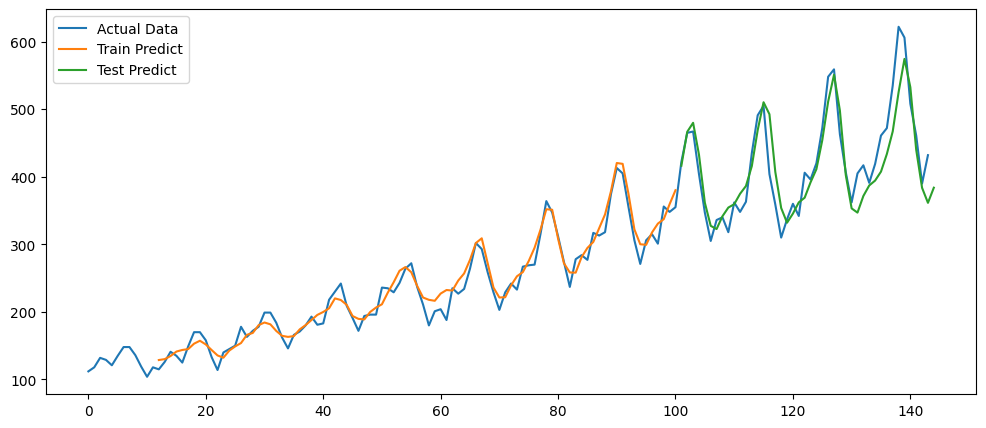

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(data, label="Actual Data")  # original

# prepare empty arrays for plotting
train_plot = np.empty_like(data)
train_plot[:] = np.nan
train_plot[look_back:len(train_predict)+look_back] = train_predict

test_plot = np.empty_like(data)
test_plot[:] = np.nan
# The start index for test_predict should be immediately after the train_predict + look_back
test_plot[len(train_predict) + look_back : len(train_predict) + look_back + len(test_predict)] = test_predict

plt.plot(train_plot, label="Train Predict")
plt.plot(test_plot, label="Test Predict")
plt.legend()
plt.show()

**Evaluate**

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Calculate RMSE for training data
train_rmse = np.sqrt(mean_squared_error(y_train_inv[0], train_predict[:,0]))
print(f"Train RMSE: {train_rmse:.2f}")

# Calculate RMSE for testing data
# Check for NaNs before calculating RMSE for test data
if np.isnan(test_predict).any() or np.isnan(y_test_inv).any():
    print("Warning: NaN values found in test_predict or y_test_inv. Filtering them out for RMSE calculation.")

    # Create masks to filter out NaNs from both prediction and true values
    nan_mask_pred = np.isnan(test_predict[:,0])
    nan_mask_true = np.isnan(y_test_inv[0])

    # Combine masks: keep elements where NEITHER prediction NOR true value is NaN
    combined_nan_mask = nan_mask_pred | nan_mask_true

    filtered_y_test_inv = y_test_inv[0][~combined_nan_mask]
    filtered_test_predict = test_predict[:,0][~combined_nan_mask]

    if len(filtered_y_test_inv) == 0:
        print("Error: No valid data points left after filtering NaNs for test RMSE calculation.")
        test_rmse = np.nan # Assign NaN if no valid points remain
    else:
        test_rmse = np.sqrt(mean_squared_error(filtered_y_test_inv, filtered_test_predict))
else:
    test_rmse = np.sqrt(mean_squared_error(y_test_inv[0], test_predict[:,0]))

print(f"Test RMSE: {test_rmse:.2f}")

Train RMSE: 15.05
Test RMSE: 35.46
